In [1]:
"""
Author https://github.com/boguss1225
Reference : https://github.com/calmisential/TensorFlow2.0_Image_Classification
"""
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import pandas as pd
import config
from utils.evaluate import eval_model
from utils.prepare_data import get_datasets, get_datasets_autosplit
from utils.pretrained_models import pretrained_model
import matplotlib.pyplot as plt


2023-03-06 12:39:40.410492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 12:39:41.424292: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-03-06 12:39:41.424372: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-03-06 12:39:41.424378: W tensorflow/c

## Select GPU

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# GPU settings
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

## Select Model

In [4]:
available_models=["Xception",
                  "EfficientNetB0", "EfficientNetB1", "EfficientNetB2",
                  "EfficientNetB3", "EfficientNetB4", "EfficientNetB5",
                  "EfficientNetB6", "EfficientNetB7",
                  "EfficientNetV2B0", "EfficientNetV2B1",
                  "EfficientNetV2B2", "EfficientNetV2B3",
                  "EfficientNetV2S", "EfficientNetV2M", "EfficientNetV2L",
                  "VGG16","VGG19",
                  "DenseNet121", "DenseNet169", "DenseNet201",
                  "NASNetLarge","NASNetMobile",
                  "InceptionV3","InceptionResNetV2"
                  ]

def get_model():
    model = pretrained_model(model_name="InceptionResNetV2",
                            load_weight=None)

    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
                  metrics=['accuracy', # add more metrics if you want
                            tf.keras.metrics.AUC(),
                            tf.keras.metrics.Precision(),
                            tf.keras.metrics.Recall(),
                            ])
    return model

## Load Data

In [5]:
# Load Data with manual data split
# train_generator, valid_generator, test_generator, \
# train_num, valid_num, test_num = get_datasets()

# Load Data with auto split
train_generator, valid_generator, test_generator, \
train_num, valid_num, test_num = get_datasets_autosplit()

Found 1751 images belonging to 12 classes.
Found 430 images belonging to 12 classes.
Found 434 images belonging to 12 classes.


In [6]:
"""
Apply image data augmentation in 'utils.prepare_data.py' manually
"""
config.image_height

128

## Visualize the data after augmentaion

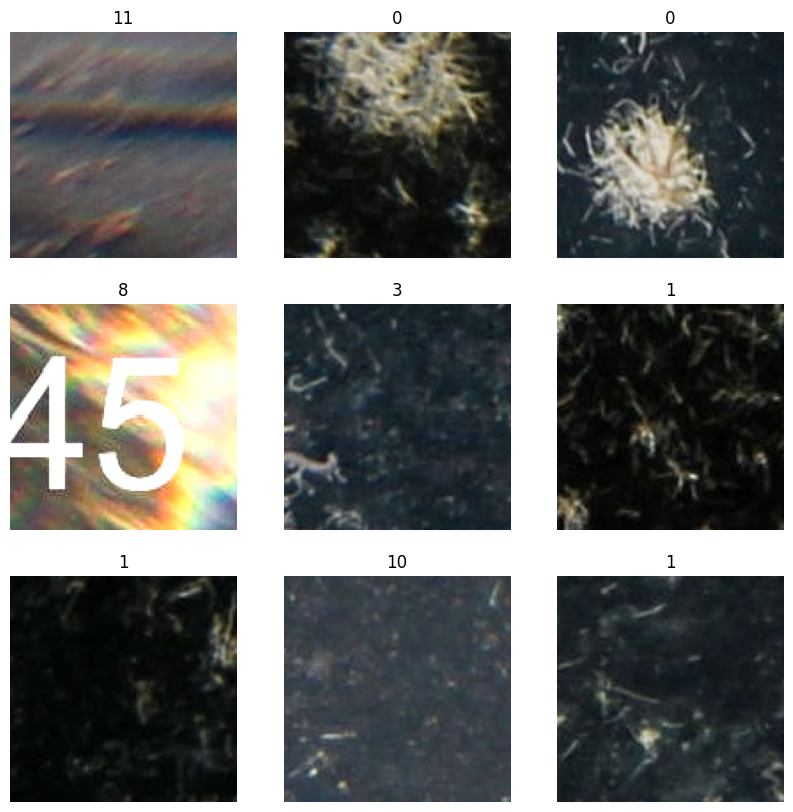

In [7]:
"""
Here are the first 9 images in the training dataset. 
Label 0 :1_thick "Beggiatoa 1 (thick mat)"
Label 1 :2_patchy "Beggiatoa 2 (patchy)"
Label 2 :3_thick "Beggiatoa 3 (thin film)"
Label 3 :3_thin "Beggiatoa 3 (thin film)"
Label 4 :3_very_thin "Beggiatoa 3 (thin film)"
Label 5 :4_thin_worm "Worm 1 (Ophryotroca shieldsii - thin colony)"
Label 6 :5_big_worm "Worm 2 (Schistomeringos lovenii - thick worms)"
Label 7 :6_dark "Background"
Label 8 :6_number "Background"
Label 9 :6_poll "Background"
Label 10 :6_soil "Background"
Label 11 :6_steel "Background"
"""
if config.BATCH_SIZE > 9 :
    range_val = 9
else :
    range_val = config.BATCH_SIZE

plt.figure(figsize=(10, 10))
for i in range(range_val):
    ax = plt.subplot(3, 3, i + 1)
    img, label = train_generator.next()
    plt.imshow(img[0].astype("uint8"))
    plt.title(label[0].argmax())
    plt.axis("off")

## Callbacks

In [8]:
"""
Callbacks
"""

# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='log')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=config.model_dir+config.model_save_name+"_best.keras",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=20,
    restore_best_weights=True
)

callbacks = [
#     tensorboard, 
    model_checkpoint_callback, 
    early_stop_callback
]

In [9]:
model = get_model()
# tf.keras.utils.plot_model(model, show_shapes=True)

2023-03-06 12:39:44.651198: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 12:39:45.128617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43654 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:81:00.0, compute capability: 8.6


## Train the model

In [ ]:
# mkdir for model save path
if not os.path.exists(config.model_dir):
    os.makedirs(config.model_dir)

print("Start training:",config.train_dir)
print("Model:", config.model_save_name)

history = model.fit(train_generator,
                    epochs=config.EPOCHS,
                    steps_per_epoch=train_num // config.BATCH_SIZE,
                    validation_data=train_generator,
                    validation_steps=valid_num // config.BATCH_SIZE,
                    callbacks=callbacks)

Start training: /home/mirap/0_DATABASE/IMAS_Salmon/7_detailed_12cls/set_all_2
Model: InceptionResNetV2_set2
Epoch 1/500


2023-03-06 12:40:22.586625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-03-06 12:40:23.947386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-06 12:40:23.952242: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x559680cd3f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-06 12:40:23.952274: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A40, Compute Capability 8.6
2023-03-06 12:40:23.957193: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-06 12:40:24.072317: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13/13 [==============================] - 80s 654ms/step - loss: 2.2804 - accuracy: 0.3062 - auc: 0.7730 - precision: 0.4366 - recall: 0.1781 - val_loss: 90455987453952.0000 - val_accuracy: 0.0599 - val_auc: 0.4872 - val_precision: 0.0599 - val_recall: 0.0599
Epoch 2/500
13/13 [==============================] - 3s 230ms/step - loss: 1.3432 - accuracy: 0.5151 - auc: 0.9182 - precision: 0.6544 - recall: 0.3722 - val_loss: 39536955392.0000 - val_accuracy: 0.0521 - val_auc: 0.4830 - val_precision: 0.0521 - val_recall: 0.0521
Epoch 3/500
13/13 [==============================] - 4s 291ms/step - loss: 1.1626 - accuracy: 0.5927 - auc: 0.9386 - precision: 0.6766 - recall: 0.4874 - val_loss: 24023776.0000 - val_accuracy: 0.0651 - val_auc: 0.4901 - val_precision: 0.0651 - val_recall: 0.0651
Epoch 4/500
13/13 [==============================] - 3s 230ms/step - loss: 1.0884 - accuracy: 0.6057 - auc: 0.9457 - precision: 0.6855 - recall: 0.5157 - val_loss: 326522.6562 - val_accuracy: 0.0651 - val_auc: 

## Save Model

In [ ]:
# save the whole model
# model.save(config.model_dir+config.model_save_name+"_last.h5")

In [ ]:
hist_df = pd.DataFrame(history.history)
with open(config.model_dir+"train_history.csv", mode='w') as f:
    hist_df.to_csv(f)

## Evaluate Model

In [ ]:
# Evaluation
eval_model(model)

## Inference Example

In [ ]:
import numpy as np
def test_single_image(img_dir, model):
    img_raw = tf.io.read_file(img_dir)
    img_tensor = tf.image.decode_jpeg(img_raw, channels=config.channels)
    img_tensor = tf.image.resize(img_tensor, [config.image_height, config.image_width])

    img_numpy = img_tensor.numpy()
    img_numpy = (np.expand_dims(img_numpy, 0))
    img_tensor = tf.convert_to_tensor(img_numpy, tf.float32)

#     img_tensor = img_tensor / 255.0 # uncomment if model included rescale preprocessing layer
    prob = model(tf.image.resize(img_tensor,[config.image_width,config.image_height]))

    
    probability = np.max(prob)

    classification = np.argmax(prob)
    return classification, probability

In [ ]:
# detect samples w last model
last_model = model
print(config.test_image_path)
classification_result, probability = test_single_image(config.test_image_path, last_model)
print("class : ",classification_result+1,"of",probability,"%")

In [ ]:
# detect samples w best model
best_model = tf.keras.models.load_model(config.model_dir+config.model_save_name+".h5")
print(config.test_image_path)
classification_result, probability = test_single_image(config.test_image_path, best_model)
print("class : ",classification_result+1,"of",probability,"%")

In [ ]:
eval_model(best_model)